In [ ]:
## Test Chronos Pipeline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [5]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon; cuda for gpu
    torch_dtype=torch.bfloat16,
)

In [6]:
df1 = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

#str(df)
df1.describe()
print(df1)

       Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]


In [7]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df1["#Passengers"])

prediction_length = 12
forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=20,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
) # forecast shape: [num_series, num_samples, prediction_length]

In [8]:
## Plot the outputs

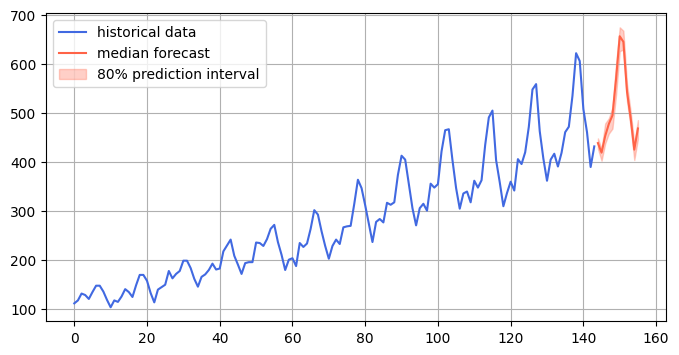

In [11]:
# visualize the forecast
forecast_index = range(len(df1), len(df1) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df1["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [68]:
df2 = pd.read_csv("https://raw.githubusercontent.com/E-DENGUE/Dengue_District_HPC/main/Data/test1.csv")

df2.describe()
print(df2)

     Unnamed: 0        date   district  m_DHF_cases    pop  \
0             1  2004-09-01  VINH HUNG           18  44492   
1             2  2004-10-01  VINH HUNG           19  44492   
2             3  2004-11-01  VINH HUNG            8  44492   
3             4  2004-12-01  VINH HUNG            5  44492   
4             5  2005-01-01  VINH HUNG            0  44908   
..          ...         ...        ...          ...    ...   
199         200  2021-04-01  VINH HUNG           13  50848   
200         201  2021-05-01  VINH HUNG           33  50848   
201         202  2021-06-01  VINH HUNG           13  50848   
202         203  2021-07-01  VINH HUNG           13  50848   
203         204  2021-08-01  VINH HUNG            5  50848   

     Dengue_fever_rates  m_DHF_cases_train  
0             40.456711               18.0  
1             42.704306               19.0  
2             17.980761                8.0  
3             11.237975                5.0  
4              0.000000       

In [101]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
logY = np.log((df2["m_DHF_cases_train"]+0.5)/df2["pop"]*10000)
logY = logY.dropna()
context = torch.tensor(logY)

prediction_length = 2
forecast_log = pipeline.predict(
    context,
    prediction_length,
    num_samples=100,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
) # forecast shape: [num_series, num_samples, prediction_length]


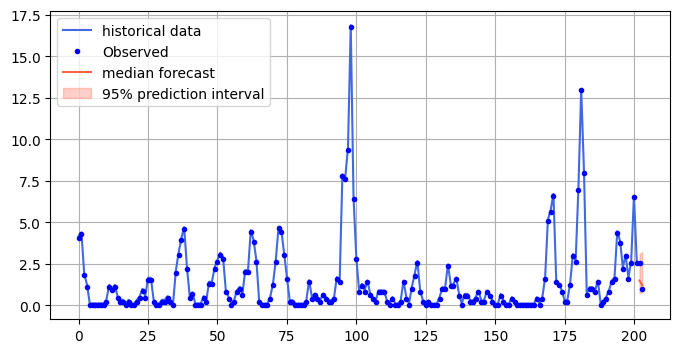

array([-0.30827216, -0.21944062])

In [110]:
# visualize the forecast
forecast_index = range(len(df2)-prediction_length, len(df2) + prediction_length-prediction_length)
low, median, high = np.quantile(forecast_log[0].numpy(), [0.025, 0.5, 0.975], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(np.exp(logY), color="royalblue", label="historical data")
plt.plot( df2["Dengue_fever_rates"]/10,'b.',  label="Observed")
plt.plot(forecast_index, np.exp(median), color="tomato", label="median forecast")

plt.fill_between(forecast_index, np.exp(low), np.exp(high), color="tomato", alpha=0.3, label="95% prediction interval")
plt.legend()
plt.grid()
plt.show()
forecast_index
low

## Identity model
Instead, try a model that dos not log transform the data first 

In [105]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
Y = (df2["m_DHF_cases"]+0.5)/df2["pop"]*10000
Y = Y.dropna()

context = torch.tensor(Y)

prediction_length = 2
forecast_id = pipeline.predict(
    context,
    prediction_length,
    num_samples=500,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
) # forecast shape: [num_series, num_samples, prediction_length]


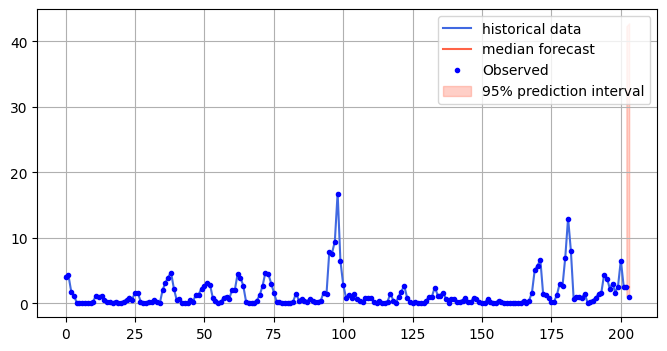

In [109]:
# visualize the forecast
forecast_index = range(len(df2)-prediction_length, len(df2) + prediction_length-prediction_length)
low, median, high = np.quantile(forecast_id[0].numpy(), [0.025, 0.5, 0.975], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(np.exp(logY), color="royalblue", label="historical data")
plt.plot(forecast_index, np.exp(median), color="tomato", label="median forecast")
plt.plot( df2["Dengue_fever_rates"]/10,'b.',  label="Observed")
plt.fill_between(forecast_index, np.exp(low), np.exp(high), color="tomato", alpha=0.3, label="95% prediction interval")
plt.legend()
plt.grid()
plt.show()

## Try to input multiple groups at once

In [121]:
df3 = pd.read_csv("https://raw.githubusercontent.com/E-DENGUE/Dengue_District_HPC/main/Data/test2.csv")

df3.describe()
print(df3)

       Unnamed: 0        date   district  m_DHF_cases       pop  \
0               1  2004-09-01    AN MINH          164  401776.0   
1               2  2004-10-01    AN MINH          111  401776.0   
2               3  2004-11-01    AN MINH           60  401776.0   
3               4  2004-12-01    AN MINH           29  401776.0   
4               5  2005-01-01    AN MINH            9  406756.0   
...           ...         ...        ...          ...       ...   
22843       22844  2021-04-01  VUNG LIEM           11  150173.0   
22844       22845  2021-05-01  VUNG LIEM            1  150173.0   
22845       22846  2021-06-01  VUNG LIEM            3  150173.0   
22846       22847  2021-07-01  VUNG LIEM            2  150173.0   
22847       22848  2021-08-01  VUNG LIEM            1  150173.0   

       Dengue_fever_rates  m_DHF_cases_train  districtID  t_index  
0               40.818765              164.0           1        1  
1               27.627335              111.0           1   

In [127]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension

Y1 = (df3["m_DHF_cases"]+0.5)/df2["pop"]*10000


Y =  pd.DataFrame({'batch': df3["districtID"], 'incidence': Y1}, index=df3["t_index"])
#Y = Y.dropna()

numpy_array = Y.values

# Convert NumPy array to a list of 1D tensors
context = [torch.tensor(row, dtype=torch.float32) for row in numpy_array]

prediction_length = 2
forecast_id = pipeline.predict(
    context,
    prediction_length,
    num_samples=10,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
) # forecast shape: [num_series, num_samples, prediction_length]